In [1]:
# %load_ext autoreload
# %autoreload 2

# Experiments with WMF-S model

In [2]:
from pathlib import Path
import numpy as np

import teaser.util as util
import teaser.evaluation as evaluation

from teaser.algorithm.wmf_s import WMF_S

## Datasets

In [3]:
## Uncomment corresponding directory.
DATA_DIR = Path('../../data/ML20M/')
# DATA_DIR = Path('../../data/Amazon Video Games/')
# DATA_DIR = Path('../../data/Publiq/')

In [4]:
# Shouldn't need to change this info
INTERACTIONS_TRAIN_PATH = DATA_DIR / 'interactions.train.csv'
INTERACTIONS_VALIN_PATH = DATA_DIR / 'interactions.valin.csv'
INTERACTIONS_VALOUT_PATH = DATA_DIR / 'interactions.valout.csv'
INTERACTIONS_TESTIN_PATH = DATA_DIR / 'interactions.testin.csv'
INTERACTIONS_TESTOUT_PATH = DATA_DIR / 'interactions.testout.csv'

METADATA_PATH = DATA_DIR / 'features.csv'

ITEM_ID = 'itemId'
USER_ID = 'userId'

## Define algorithm and hyperparameter ranges

In [5]:
ALG = WMF_S

L2 = [10 ** p for p in range(1, 5)]
ALPHA = [10 ** p for p in range(0, 3)]
HYPERPARAMS = {'l2': L2, 'alpha': ALPHA}
HYPERPARAMS

{'l2': [10, 100, 1000, 10000], 'alpha': [1, 10, 100]}

## Parse data

In [6]:
S, tags = util.parse_metadata(METADATA_PATH, item_id=ITEM_ID)
n, t = S.shape  # amount of items and tags

X = util.parse_interactions(INTERACTIONS_TRAIN_PATH, item_id=ITEM_ID, user_id=USER_ID, shape_items=n)

Xval_in = util.parse_interactions(INTERACTIONS_VALIN_PATH, item_id=ITEM_ID, user_id=USER_ID, shape_items=n)
Xval_out = util.parse_interactions(INTERACTIONS_VALOUT_PATH, item_id=ITEM_ID, user_id=USER_ID, shape_items=n)
Xtest_in = util.parse_interactions(INTERACTIONS_TESTIN_PATH, item_id=ITEM_ID, user_id=USER_ID, shape_items=n)
Xtest_out = util.parse_interactions(INTERACTIONS_TESTOUT_PATH, item_id=ITEM_ID, user_id=USER_ID, shape_items=n)

In [7]:
# # debug
# d_items = 1000
# S = S[:d_items,:]
# tags = tags[:d_items]
# X = X[:,:d_items]
# Xval_in = Xval_in[:,:d_items]
# Xval_out = Xval_out[:,:d_items]
# Xtest_in = Xtest_in[:,:d_items]
# Xtest_out = Xtest_out[:,:d_items]

## Perform gridsearch on validation set

In [8]:
score, best_hyperparams = evaluation.gridsearch(ALG, X, S, Xval_in, Xval_out, HYPERPARAMS)

Training model WMF_S with hyperparameters {'l2': 10, 'alpha': 1}
Evaluating with 10000 users
Average Recall@20 0.165
Average Recall@100 0.298
Average nDCG@100 0.199
Training model WMF_S with hyperparameters {'l2': 100, 'alpha': 1}
Evaluating with 10000 users
Average Recall@20 0.214
Average Recall@100 0.385
Average nDCG@100 0.253
Training model WMF_S with hyperparameters {'l2': 1000, 'alpha': 1}
Evaluating with 10000 users
Average Recall@20 0.215
Average Recall@100 0.406
Average nDCG@100 0.256
Training model WMF_S with hyperparameters {'l2': 10000, 'alpha': 1}
Evaluating with 10000 users
Average Recall@20 0.19
Average Recall@100 0.374
Average nDCG@100 0.226
Training model WMF_S with hyperparameters {'l2': 10, 'alpha': 10}
Evaluating with 10000 users
Average Recall@20 0.133
Average Recall@100 0.256
Average nDCG@100 0.165
Training model WMF_S with hyperparameters {'l2': 100, 'alpha': 10}
Evaluating with 10000 users
Average Recall@20 0.203
Average Recall@100 0.373
Average nDCG@100 0.242
Tr

In [9]:
f"Best score of {score} achieved with {best_hyperparams}."

"Best score of 0.26313325384785846 achieved with {'l2': 1000, 'alpha': 10}."

## Evaluate model with optimal hyperparams on test set

In [10]:
%%time
alg = ALG(**best_hyperparams)
alg.fit(X, S)

CPU times: user 25.3 s, sys: 75.7 ms, total: 25.4 s
Wall time: 1.65 s


In [11]:
%%time
print("Performance on test set")
score = evaluation.eval(alg, Xtest_in, Xtest_out)

Performance on test set
Evaluating with 10000 users
Average Recall@20 0.221
Average Recall@100 0.419
Average nDCG@100 0.263
CPU times: user 5h 35min 15s, sys: 7h 48min 46s, total: 13h 24min 1s
Wall time: 26min 14s


## Plot amount of items from long tail recommended

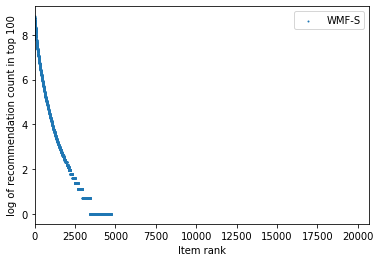

In [12]:
# evaluation.plot_long_tail(alg, Xtest_in=Xtest_in, Xtest_out=Xtest_out, labels=["EASE", "Test items"], k=100)
evaluation.plot_long_tail(alg, histories=Xtest_in, labels=["WMF-S"], k=100)